# Part 3 ‐ Predictive Modeling

Ultimate is interested in predicting rider retention. Let's consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

## Import Libraries

In [1]:
import json
import pandas as pd
import datetime
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
####
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#####
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve

## Read Data

In [2]:
file = open('ultimate_data_challenge.json', 'r')
df = pd.DataFrame(json.load(file))
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


## Data Wrangling

### 1. Check for NULL Values

In [4]:
df.columns[df.isna().any()].tolist()

['avg_rating_by_driver', 'avg_rating_of_driver', 'phone']

### 2. Handle NAN Values

#### avg_rating_by_driver

In [5]:
df.avg_rating_by_driver.round().value_counts()

5.0    41547
4.0     7248
3.0      661
1.0      181
2.0      162
Name: avg_rating_by_driver, dtype: int64

In [6]:
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna((df['avg_rating_by_driver'].mean()))

#### avg_rating_of_driver

In [7]:
df.avg_rating_of_driver.round().value_counts()

5.0    28060
4.0    11713
3.0     1504
2.0      345
1.0      256
Name: avg_rating_of_driver, dtype: int64

In [8]:
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna((df['avg_rating_of_driver'].mean()))

#### Phone

In [9]:
df.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [10]:
df['phone'] = df['phone'].fillna("iPhone")

### 3.Change Column Type

In [11]:
# Convert last trip and sign up columns to datetime objects
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [12]:
df.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [13]:
df["city"] = df["city"].astype("category")
df["phone"] = df["phone"].astype("category")

### 4. Add new Column

#### Span - How Long the User is Booking Trips with Ultimate

In [14]:
df["span"] = (df['last_trip_date'] - df['signup_date']).astype('timedelta64[D]')

#### prefers_weekdays -  Does the user prefers a weekday or a weekend

In [15]:
df["prefers_weekdays"] = np.where((df["weekday_pct"] >= 50),1, 0)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null category
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null category
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
span                      50000 non-null float64
prefers_weekdays          50000 non-null int64
dtypes: bool(1), category(2), datetime64[ns](2), float64(7), int64(2)
memory usage: 4.3 MB


## Exploratory Analysis

#### 1. Average Distance - Average Distance in miles per trip taken in the first 30 days after signup

/Users/oindrilasen/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


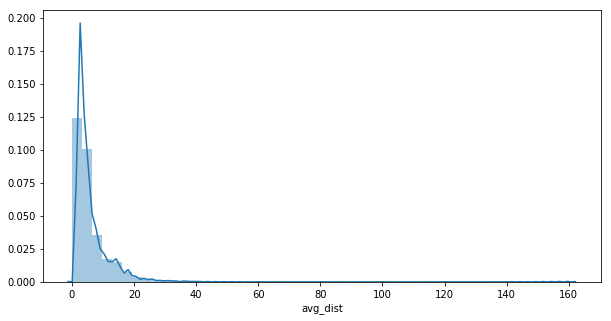

In [17]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes()
sns.distplot(df.avg_dist)

#### 2. Avereage ratings By Drivers -  How the drivers rate their users?

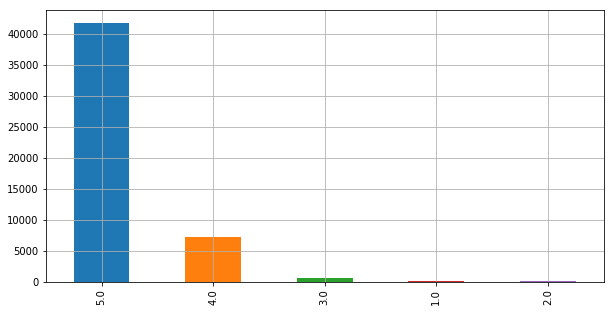

In [18]:
df.avg_rating_by_driver.round().value_counts().plot("bar",figsize = (10,5), grid = True)

#### 3. Average Ratings Of Drivers - How the users rate their Drivers?

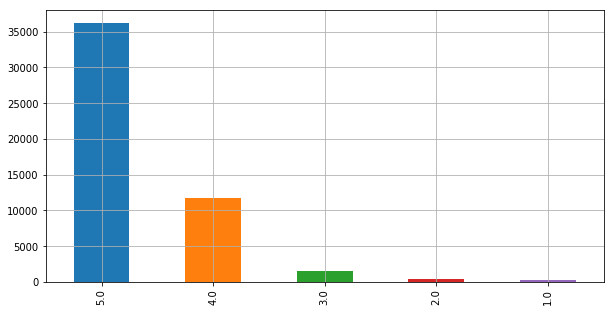

In [19]:
df.avg_rating_of_driver.round().value_counts().plot("bar",figsize = (10,5), grid = True)

#### 4. City - How Data across City is distributed?

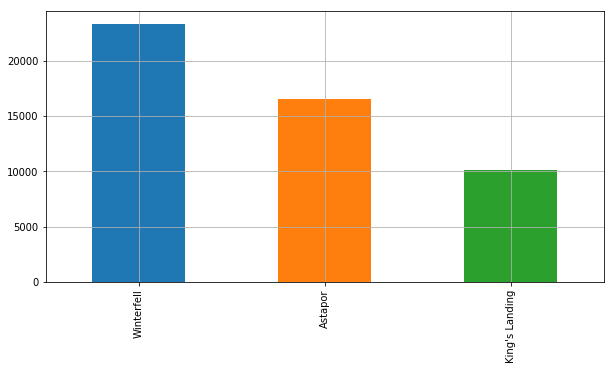

In [20]:
df.city.value_counts().plot("bar", figsize = (10,5), grid = True)

#### 5. Phone -  Which Primary Device among Users are more popular?

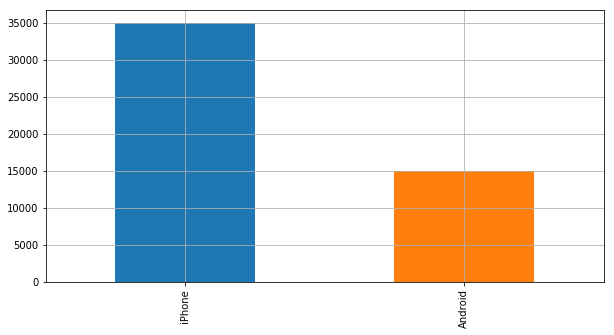

In [21]:
df.phone.value_counts().plot("bar",figsize = (10,5), grid = True)

#### 6. Trips in First 30 Days - Number of trips Users took in the first 30 days after signing up

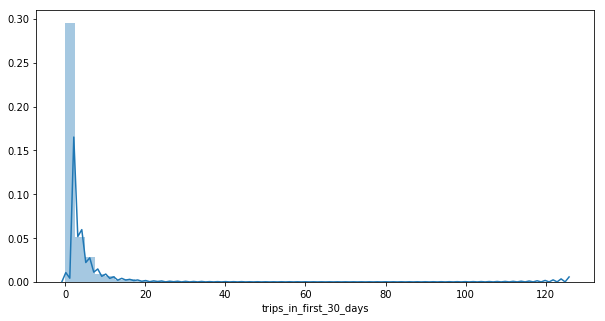

In [22]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes()
sns.distplot((df.trips_in_first_30_days) )

#### 7. Ultimate Black  - How many users book Ultimate Black in their first 30 days

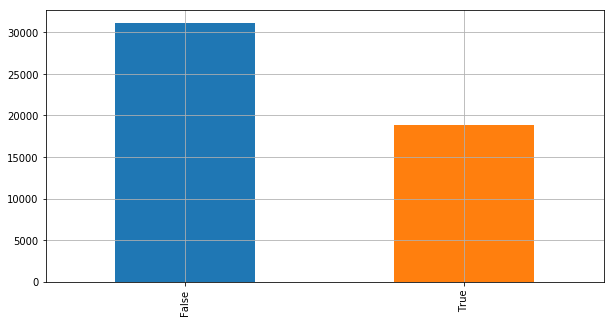

In [23]:
df.ultimate_black_user.value_counts().plot("bar",figsize = (10,5), grid = True)

#### 8. Span - How Long the User is Active

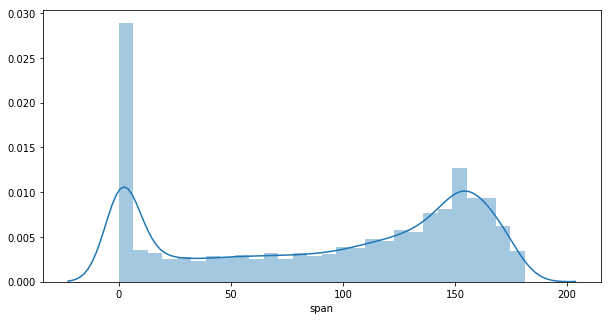

In [24]:
fig = plt.figure(figsize=(10,5))
ax = plt.axes()
sns.distplot((df.span) )

#### 9. Prefers Weekdays -  Check if Users Books their Rides on Weekdays of Weekends

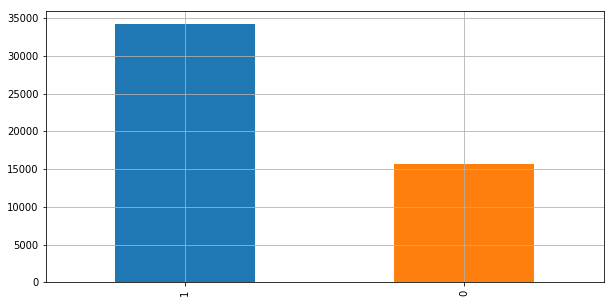

In [25]:
df.prefers_weekdays.value_counts().plot("bar",figsize = (10,5), grid = True)

## Build a Predictive Model

First, Let's take a look at our current dataset.

In [26]:
df.head(2)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,span,prefers_weekdays
0,3.67,5.0,4.7,1.1,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,143.0,0
1,8.26,5.0,5.0,1.0,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,96.0,1


#### Check signup_date

In [27]:
df.signup_date.describe()

count                   50000
unique                     31
top       2014-01-18 00:00:00
freq                     2948
first     2014-01-01 00:00:00
last      2014-01-31 00:00:00
Name: signup_date, dtype: object

#### All the users signed up for an Ultimate account in January 2014

#### Check last_trip_date

In [28]:
df.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [29]:
df.last_trip_date.describe()

count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

#### The data was pulled on 01 July 2014

#### Condition: Consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

#### Get Active Users

In [30]:
# creating a column that shows whether the user is active
df['active_user'] = (df['last_trip_date'].max() - df['last_trip_date']) < timedelta(30)
df['active_user'] = df['active_user'].astype(int)

In [31]:
df.active_user.value_counts()

0    31690
1    18310
Name: active_user, dtype: int64

#### Convert Boolean Value to Interger

In [32]:
df['ultimate_black_user'] = df['ultimate_black_user'].astype(int)

#### Encode Categorical Features

In [33]:
# One-hot-encode for categorical features via .get_dummies pandas method
df_final = pd.get_dummies(df, columns = ['city', 'phone', 'ultimate_black_user',"prefers_weekdays"])
df_final.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,weekday_pct,span,active_user,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_0,ultimate_black_user_1,prefers_weekdays_0,prefers_weekdays_1
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,46.2,143.0,1,0,1,0,0,1,0,1,1,0
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,50.0,96.0,0,1,0,0,1,0,1,0,0,1
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,100.0,1.0,0,1,0,0,0,1,1,0,0,1
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,80.0,170.0,1,0,1,0,0,1,0,1,0,1
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,82.4,47.0,0,0,0,1,1,0,1,0,0,1


Here is our final Dataset, ready to build a Model.

In [34]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
weekday_pct               50000 non-null float64
span                      50000 non-null float64
active_user               50000 non-null int64
city_Astapor              50000 non-null uint8
city_King's Landing       50000 non-null uint8
city_Winterfell           50000 non-null uint8
phone_Android             50000 non-null uint8
phone_iPhone              50000 non-null uint8
ultimate_black_user_0     50000 non-null uint8
ultimate_black_user_1     50000 non-null uint8
prefers_weekd

#### Split data into Training And Test dataset

In [35]:
y = df_final['active_user']
X = df_final.drop(['active_user','last_trip_date','signup_date','span'], axis=1)

In [36]:
# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=21)

In [37]:
X_train.shape

(35000, 16)

In [38]:
X_test.shape

(15000, 16)

### Random Forest Model

In [39]:
# Random Forest Model
random_model = RandomForestClassifier(n_estimators = 1000,
                                     min_samples_split= 2,
                                     min_samples_leaf= 2, 
                                     max_features='auto',
                                     max_depth=None,
                                     random_state = 42)

#### Fit the Model

In [40]:
random_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

#### Check Feature Importance

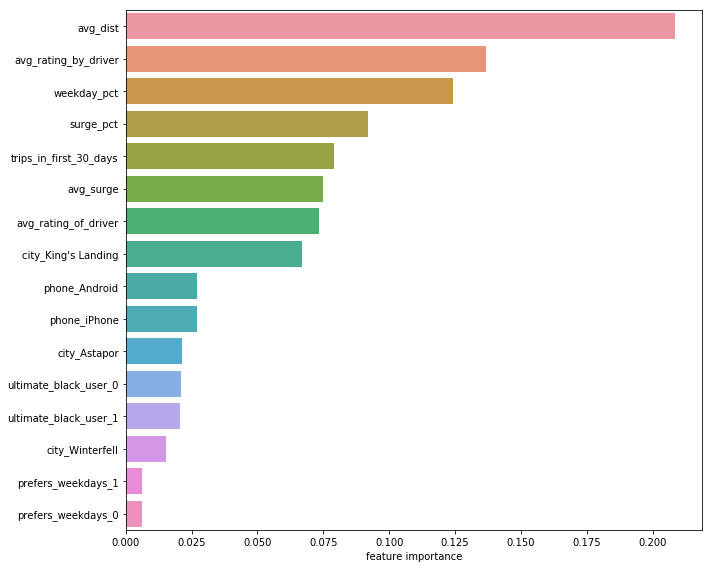

In [41]:
f, ax = plt.subplots(figsize=(10, 8))
ranking = np.argsort(-random_model.feature_importances_)
ax = sns.barplot(x=random_model.feature_importances_[ranking][:20], y=X_train.columns.values[ranking][:20], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

### Predict On Test Data

In [42]:
y_pred_random = random_model.predict(X_test)
y_pred_random

array([1, 0, 0, ..., 0, 0, 0])

### Check Accuracy of the Model

In [43]:
# print accuracy score
accuracy = random_model.score(X_test,y_test)
print("Random Forest accuracy:",accuracy)

Random Forest accuracy: 0.7765333333333333


### Confusion Matrix

In [44]:
results = confusion_matrix(y_test, y_pred_random) 
print(results)

[[8087 1394]
 [1958 3561]]


### Cleassification Report

In [45]:
print(classification_report(y_test, y_pred_random) )

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      9481
           1       0.72      0.65      0.68      5519

   micro avg       0.78      0.78      0.78     15000
   macro avg       0.76      0.75      0.75     15000
weighted avg       0.77      0.78      0.77     15000



### ROC Curve

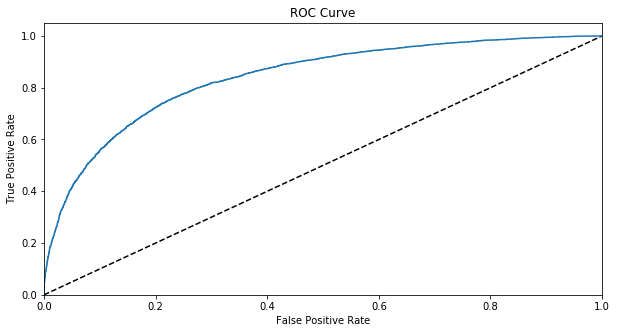

In [46]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = random_model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()


## Conclusion

The Random Forest Model is **78%** Accurate.

Ultimate can try to take advantage of the Feture Importance plot. 
Now, let's check out a few features for not-so-active users and come to a conclusion.

In [50]:
df[df.active_user == 0]["avg_dist"].describe()

count    31690.000000
mean         6.188478
std          6.213027
min          0.000000
25%          2.320000
50%          4.030000
75%          7.770000
max        129.890000
Name: avg_dist, dtype: float64

Apart from a few outliers, the Inactive Users have travelled less distance. May be some promotions or offers can inspire these users to travel more with Ultimate. 

In [51]:
df[df.active_user == 0]["avg_rating_by_driver"].round().value_counts()

5.0    26469
4.0     4348
3.0      567
1.0      161
2.0      145
Name: avg_rating_by_driver, dtype: int64

It looks like drivers have rated positively for most of the users. So, can't think of any improvement here!

In [52]:
df[df.active_user == 0]["weekday_pct"].describe()

count    31690.000000
mean        60.181597
std         40.985698
min          0.000000
25%         16.700000
50%         66.700000
75%        100.000000
max        100.000000
Name: weekday_pct, dtype: float64

It seems like the Inactive users travveled mostly on week days. May be the Rides availabity were less or the waiting time was more. Further investigation can reveal some interesting facts.

In [53]:
df[df.active_user == 0]["city"].value_counts()

Winterfell        15355
Astapor           12512
King's Landing     3823
Name: city, dtype: int64

In [54]:
df[df.active_user == 1]["city"].value_counts()

Winterfell        7981
King's Landing    6307
Astapor           4022
Name: city, dtype: int64

Interstingly, city king's Landing seems to be an important predictor. 
The users from King's Landing are more Active. The roads are better or more drivers are available in this city?